# Hartree-Fock

Copyright (C) 2021, Oriol Vendrell <oriol.vendrell@uni-heidelberg.de>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

In [1]:
import numpy as np
import numpy.linalg.linalg as alg
import matplotlib.pyplot as plt

from matplotlib import colors
divnorm = colors.TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1.0)
divnorm0 = colors.TwoSlopeNorm(vmin=-0.1, vcenter=0.0, vmax=0.1)

### Utilities

In [2]:
def diagonalize(mat):
    """
    Diagonalize real symmetric matric mat. Return eigenvalues and eigenvectors in ascending order.
    """
    e, v = alg.eigh(mat)
    s = np.argsort(e)
    e = e[s]
    v = v[:,s]
    return e, v

In [3]:
def set_coefficients(vMO, N):
    """
    Return the first N columns of the vMO matrix containing MO coefficients
    """
    NAO = len(vMO)
    C = np.zeros((NAO, N), float)
    for k in range(N):
        C[:, k] = vMO[:, k]
    return C

In [115]:
def coulomb_operator(v2b, c):
    """
    Construct the Coulomb operator J = \sum_j J_j, where J_j is the Coulomb operator of the j-th molecular orbital
    
    v2b -- 2-body interaction in the primitive (AO) basis
    c -- matrix of molecular orbital coefficient vectors, shape=(NAO, N) (columnwise)
    """
    NAO = len(c)
    Jtot = np.zeros((NAO, NAO), float)
    for MOj in c.T:
        Jj = np.zeros((NAO, NAO), float)
        for r1 in range(NAO):
            for r2 in range(NAO):
                    Jj[r1, r2] = Jj[r1, r2] + v2b[r1, r2]*MOj[r2]**2
        Jtot = Jtot + Jj
    return Jtot

In [116]:
def exchange_operator(v2b, c):
    """
    Construct the total exchange operator K = \sum_j \sum_l K_jl for each pair of molecular orbitals
    
    v2b -- 2-body interaction in the primitive (AO) basis
    c -- matrix of molecular orbital coefficient vectors, shape=(NAO, N) (columnwise)
    """
    NAO = len(c)
    Ktot = np.zeros((NAO, NAO), float)
    for MOj in c.T:
        for MOk in c.T:
            Kjk = np.zeros((NAO, NAO), float)
            for r1 in range(NAO):
                for r2 in range(NAO):
                    Kjk[r1, r2] = Kjk[r1, r2] + v2b[r1, r2]*MOj[r2]*MOk[r2]
            Ktot = Ktot + Kjk
    return Ktot

In [117]:
def mo_op_energy(op, c):
    op_mo = np.dot(c.T, np.dot(op, c))
    return np.ravel(op_mo).sum()

### System specification

In [243]:
Nsites = 10 # nr. of sites (e.g. localized atomic orbitals)

T = -1.0 # hopping integral
U = 0.05  # on-site interaction

Na = 8   # nr. alpha spin-orbitals
Nb = 8   # nr. beta spin-orbitals

In [219]:
h = np.zeros((Nsites, Nsites), float)
for r1 in range(Nsites - 1):
    h[r1, r1 + 1] = h[r1 + 1, r1] = T

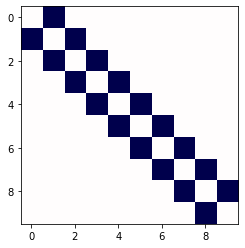

In [220]:
plt.imshow(h, interpolation='none', cmap='seismic', norm=divnorm)
plt.show()

In [221]:
v = np.zeros((Nsites, Nsites), float)
for r1 in range(Nsites):
    for r2 in range(Nsites):
        v[r1, r2] = U/(1 + np.abs(r2-r1))

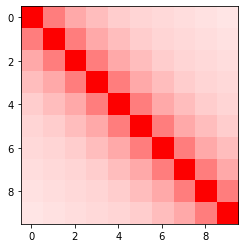

In [222]:
plt.imshow(v, interpolation='none', cmap='seismic', norm=divnorm0)
plt.show()

In [223]:
# Diagonalize core Hamiltonian
e, vMO = diagonalize(h)
noiseA = np.random.rand(Nsites, Nsites)*0.0
noiseB = np.random.rand(Nsites, Nsites)*0.0
for i in range(Nsites):
    for j in range(i, Nsites):
        noiseA[i, j] = noiseA[j ,i]
        noiseB[i, j] = noiseB[j ,i]
e, vMOa = diagonalize(h + noiseA)
e, vMOb = diagonalize(h + noiseB)

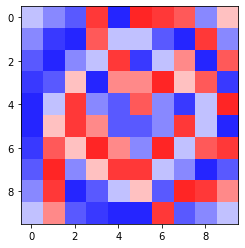

In [224]:
plt.imshow(vMO_a, interpolation='none', cmap='seismic', norm=divnorm)
plt.show()

In [225]:
S = np.dot(vMO.T, vMO)

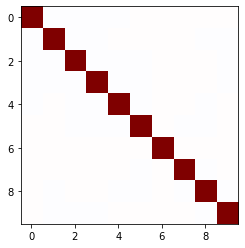

In [226]:
plt.imshow(S, interpolation='none', cmap='seismic', norm=divnorm)
plt.show()

In [244]:
# Initialize orbitals using the eigenvectors of the core Hamiltonian
# alpha orbitals
Ca = set_coefficients(vMOa, Na)
# beta orbitals
Cb = set_coefficients(vMOb, Nb)

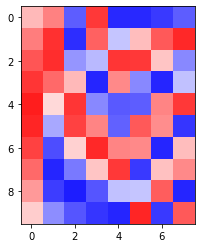

In [245]:
plt.imshow(Ca, interpolation='none', cmap='seismic', norm=divnorm)
plt.show()

In [246]:
# Hartree-Fock iterations
nIter = 20
for n in range(nIter):
    Ja = coulomb_operator(v, Ca)
    Jb = coulomb_operator(v, Cb)
    Ka = exchange_operator(v, Ca)
    Kb = exchange_operator(v, Cb)
    Fa = h + Ja + Jb - Ka
    Fb = h + Ja + Jb - Kb
    ea, vMOa = diagonalize(Fa)
    eb, vMOb = diagonalize(Fb)
    Ca = set_coefficients(vMOa, Na)
    Cb = set_coefficients(vMOb, Na)
    
    orbital_energy = ea[0:Na].sum() + eb[0:Nb].sum()
    e_Ja = mo_op_energy(Ja, Ca) + mo_op_energy(Ja, Cb)
    e_Jb = mo_op_energy(Jb, Ca) + mo_op_energy(Jb, Cb)
    e_Ka = mo_op_energy(Ka, Ca)
    e_Kb = mo_op_energy(Kb, Cb)
    
    e_hf = orbital_energy - 0.5*(e_Ja - e_Ka) - 0.5*(e_Jb - e_Kb)
    
    print('E_HF: ', e_hf)
    #print('Eb: ', eb)

E_HF:  -6.632867141928509
E_HF:  -6.292364657728019
E_HF:  -6.27763112054939
E_HF:  -6.280809237016065
E_HF:  -6.280091640145185
E_HF:  -6.2802108503729865
E_HF:  -6.280187246317981
E_HF:  -6.280191609369123
E_HF:  -6.280190773649068
E_HF:  -6.280190930587075
E_HF:  -6.280190900865012
E_HF:  -6.280190906469233
E_HF:  -6.2801909054102065
E_HF:  -6.280190905610116
E_HF:  -6.280190905572362
E_HF:  -6.2801909055794924
E_HF:  -6.280190905578145
E_HF:  -6.2801909055784
E_HF:  -6.280190905578351
E_HF:  -6.280190905578364


In [240]:
rho_a = np.zeros(Nsites, float)
rho_b = np.zeros(Nsites, float)
for r1 in range(Nsites):
    C2a = Ca[r1,:]*Ca[r1,:]
    C2b = Cb[r1,:]*Cb[r1,:]
    rho_a[r1] = C2a.sum()
    rho_b[r1] = C2b.sum()
rho_a = rho_a/Na
rho_b = rho_b/Nb
#plt.imshow(rho_a, interpolation='none', cmap='seismic', norm=divnorm)
rho = [rho_a, rho_b, (rho_a + rho_b)/2.0]
rho = np.asarray(rho).T

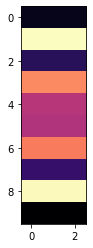

In [241]:
plt.imshow(rho, interpolation='none', cmap='magma')
plt.show()

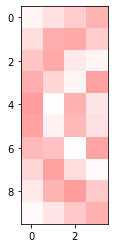

In [242]:
plt.imshow(Ca**2, interpolation='none', cmap='seismic', norm=divnorm)
plt.show()